In [133]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, MolToImage

In [2]:
# upload the vasopressin dataset
data = pd.read_csv("data/chembl_Vasopressin_V1a_receptor_KI.csv", delimiter = ";")

smiles = data["Smiles"]
smiles.fillna("", inplace = True)
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
data["molecule"] = molecules

# add Morgan fingerprints to the dataframe
data["morgan_fingerprint"] = data["molecule"].apply(Chem.GetMorganFingerprintAsBitVect, args = (2, ), nBits = 1024)

In [5]:
# upload the drugbank dataset
drugbank = [m for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m]

RDKit ERROR: [10:07:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:07:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:07:33] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [10:07:33] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [10:07:33] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[10:07:33] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[10:07:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

RDKit ERROR: [10:07:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [10:07:34] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [10:07:34] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [10:07:34] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:07:34] ERROR: Could not sanitize molecule ending on line 250947
[10:07:34] ER

[10:07:34] ERROR: Could not sanitize molecule ending on line 357505
RDKit ERROR: [10:07:34] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:07:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [10:07:34] ERROR: Could not sanitize molecule ending on line 371006
[10:07:34] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13

[10:07:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

[10:07:34] ERROR: Could not sanitize molecule ending on line 371006
RDKit ERROR: [10:07:34] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [10:07:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
[10:07:34] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

[10:07:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9

RDKit ERROR: [10:07:34] ERROR: Could not sanitize molecule ending on line 378618
[10:07:34] ERROR: Could not saniti

RDKit ERROR: [10:07:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[10:07:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17

[10:07:35] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27

RDKit ERROR: 
RDKit ERROR: [10:07:35] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit ERROR: 
RDKit ERROR: [10:07:35] ERROR: Could not sanitize molecule ending on line 574645
[10:07:35] ERROR: Could not sanitize molecule ending on line 574645
RDKit ERROR: [10:07:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[10:07:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27

[10:07:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9

RDKit ERROR: 
RDKit ERROR: [10:07:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:07:35] ERROR: Could not sanitize molecule ending on line 592639
[10:07:35] ERROR: Could not sanitize molecule ending on line 592639
RDKit ERROR: [10:07:35

In [6]:
# create the drugbank dataframe
drugbank_morgan_fingerprint = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in drugbank]
drugbank_formulas = [m.GetProp("FORMULA") for m in drugbank]
drugbank_generics = [m.GetProp("GENERIC_NAME") for m in drugbank]

drugbank_df = pd.DataFrame([drugbank_formulas, drugbank_generics, drugbank, drugbank_morgan_fingerprint]).transpose()
drugbank_df.columns = ["formula", "generic_name", "molecule", "morgan_fingerprint"]

In [12]:
# function to return the silimarity index of two bit vectors
def tanimoto_index(bit_vector1, bit_vector2):
    intersect = [bit1 and bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    union = [bit1 or bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    try:
        index = sum(intersect) / sum(union)
    except ZeroDivisionError:
        return 0
    return index

In [27]:
self_similarity_matrix = pd.DataFrame(index = data["Molecule ChEMBL ID"], columns = data["Molecule ChEMBL ID"])

for row1 in data.index:
    for row2 in range(row1 + 1, len(data.index)):
        name1, fingerprint1 = data.loc[row1, ["Molecule ChEMBL ID", "morgan_fingerprint"]]
        name2, fingerprint2 = data.loc[row2, ["Molecule ChEMBL ID", "morgan_fingerprint"]]

        self_similarity_matrix.loc[name1, name2] = tanimoto_index(fingerprint1, fingerprint2)

In [29]:
self_similarity_matrix.to_csv("vasopressin_self_similarity_matrix.csv")

## Scaffolds

In [162]:
# create three different levels of scaffolds for the vasopressin dataset
data["scaffold"] = data["molecule"].apply(GetScaffoldForMol)
data["scaffold_generic"] = data["scaffold"].apply(MakeScaffoldGeneric)
data["scaffold_scaffold_generic"] = data["scaffold_generic"].apply(GetScaffoldForMol)

In [163]:
# create the roughest scaffolds for the DrugBank dataset
drugbank_df["scaffold"] = drugbank_df["molecule"].apply(GetScaffoldForMol)

RDKit WARNING: [13:14:34] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:14:34] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


In [164]:
data["scaffold_smiles"] = data["scaffold_scaffold_generic"].apply(Chem.MolToSmiles)
drugbank_df["scaffold_smiles"] = drugbank_df["scaffold"].apply(Chem.MolToSmiles)

In [165]:
data_scaffold_counts = data["scaffold_smiles"].value_counts()
data_scaffold_counts = data_scaffold_counts.sort_values(ascending = False)

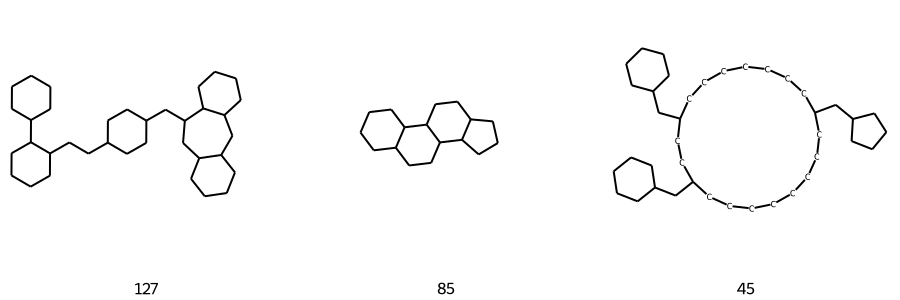

In [172]:
# visualize second to fifth most common scaffolds
legend = [str(v) for v in data_scaffold_counts.values]
to_draw = [Chem.MolFromSmiles(m) for m in data_scaffold_counts.index]
to_draw = [m for m in to_draw if m]
# MolToImage(to_draw[0])
MolsToGridImage(to_draw[2:5], subImgSize = (300, 300), legends = legend)

In [188]:
data_top_ten_scaffold_smiles = data_scaffold_counts.index[:10]
data["top_ten_scaffolds"] = data["scaffold_smiles"].apply(str).isin(data_top_ten_scaffold_smiles)

In [37]:
drugbank_df["scaffold_smiles"].value_counts()

                                                                                                                             982
c1ccccc1                                                                                                                     637
C1CCOCC1                                                                                                                     131
c1ncc2ncn([C@H]3CCCO3)c2n1                                                                                                   100
c1ccc2ccccc2c1                                                                                                                49
                                                                                                                            ... 
O=C1CCCC/C=C\C=C/C[C@@H](/C=C/C=C/CCCCC[C@H]2CCC[C@@]3(CCCC(=O)N3)O2)OC(=O)[C@@H]2CCCN(N2)C(=O)[C@@H](Cc2ccccc2)NC(=O)CN1      1
O=C(CCc1ccccc1)N[C@@H](Cc1cnc[nH]1)C(=O)NCCC1CCCCC1                                              

In [69]:
drugbank_scaffold_counts = drugbank_df["scaffold_smiles"].value_counts()
drugbank_scaffold_counts = drugbank_scaffold_counts.sort_values(ascending = False)

RDKit ERROR: [13:11:05] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:11:05] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:11:05] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:11:05] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit WARNING: [13:11:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:11:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


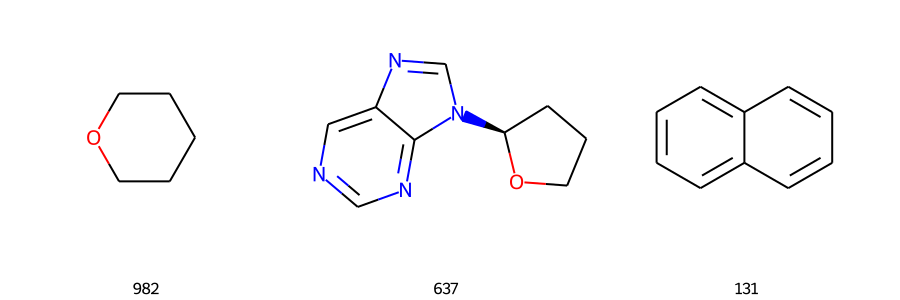

In [158]:
# visualize second to fifth most common scaffolds
legend = [str(v) for v in drugbank_scaffold_counts.values]
to_draw = [Chem.MolFromSmiles(m) for m in drugbank_scaffold_counts.index]
to_draw = [m for m in to_draw if m]
MolsToGridImage(to_draw[2:5], subImgSize = (300, 300), legends = legend)